In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import spacy

from collections import Counter
from collections import defaultdict

import os
from tqdm import tqdm
import math
from math import log2
import re
import json

import openai
from dotenv import load_dotenv
from typing import List

from sklearn.metrics import accuracy_score, f1_score, classification_report

## Load data and models

Models

In [5]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hadrienstrichard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nlp_fr = spacy.load("fr_core_news_sm") 

Data

In [7]:
texts = pd.read_parquet('../Data/excerpts_processed.parquet')

texts.head()

,Author,Title,URL,Excerpt_ID,Excerpt_Text,Cleaned_Text,Tokens
0,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_21,«--Hé! hé! monsieur Antoine; voulez-vous venir...,"""--hé! hé! monsieur antoine; voulez-vous venir...","[``, --, hé, !, hé, !, monsieur, antoine, ;, v..."
1,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_51,"«Cette demoiselle est fort taquine, pensa-t-il...","""cette demoiselle est fort taquine, pensa-t-il...","[``, cette, demoiselle, est, fort, taquine, ,,..."
2,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_50,"Mais l'accent, mais le regard, trouvent dans l...","mais l'accent, mais le regard, trouvent dans l...","[mais, l'accent, ,, mais, le, regard, ,, trouv..."
3,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_14,"--Qu'il s'en aille! et toi ... garde ta place,...","--qu'il s'en aille! et toi ... garde ta place,...","[--, qu'il, s'en, aille, !, et, toi, ..., gard..."
4,George Sand,Pauline,https://www.gutenberg.org/ebooks/12447,12447_11,"Mais, quoiqu'elle y mît de l'affection et de l...","mais, quoiqu'elle y mît de l'affection et de l...","[mais, ,, quoiqu'elle, y, mît, de, l'affection..."


In [8]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Author        3858 non-null   object
 1   Title         3858 non-null   object
 2   URL           3858 non-null   object
 3   Excerpt_ID    3858 non-null   object
 4   Excerpt_Text  3858 non-null   object
 5   Cleaned_Text  3858 non-null   object
 6   Tokens        3858 non-null   object
dtypes: object(7)
memory usage: 211.1+ KB


## Function words

In [9]:
# Load French function words (common stopwords in French) as our function word list.
french_function_words = set(stopwords.words('french'))
print(f"Number of French function words: {len(french_function_words)}")
# Optionally, inspect a few function words
print("Sample function words:", list(french_function_words)[:10])

Number of French function words: 157
Sample function words: ['étés', 'moi', 'étions', 'ont', 'auront', 'en', 'eusse', 'nous', 'auriez', 't']


In [10]:
# Define a set of punctuation marks we will consider for certain features.
punct_set = {'.', ',', ';', '!', '?', ':', '-', '—', '(', ')', '[', ']', '{', '}', '"', "'", '«', '»'}

In [11]:
# Compute total number of words (excluding punctuation) for each text, to use in normalization
texts['WordCount'] = texts['Tokens'].apply(lambda tokens: sum(1 for t in tokens if t not in punct_set))

# Add one feature column for each function word in the list
for fw in french_function_words:
    col_name = f"fw_{fw}"
    # Normalized frequency: count of fw divided by number of words (avoid division by zero)
    texts[col_name] = texts.apply(
        lambda row: row['Tokens'].count(fw) / row['WordCount'] if row['WordCount'] > 0 else 0.0,
        axis=1
    )

# Example: check a few function word feature columns for the first text
print(texts.loc[0, ['Author'] + [f"fw_{w}" for w in list(french_function_words)[:5]]])
print(texts.info())

/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

Author       George Sand
fw_étés              0.0
fw_moi           0.00185
fw_étions            0.0
fw_ont               0.0
fw_auront            0.0
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 165 entries, Author to fw_serons
dtypes: float64(157), int64(1), object(7)
memory usage: 4.9+ MB
None


/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3428490745.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col_name] = texts.apply(


In [12]:
# Define function word groups
func_word_groups = {
    "gfw_article": {"le", "la", "les", "un", "une", "du", "des"},
    "gfw_preposition": {"à", "de", "en", "dans", "avec", "sans", "sous", "sur", "chez"},
    "gfw_pronoun": {"je", "tu", "il", "elle", "nous", "vous", "ils", "elles", "on", "lui", "leur", "se", "me", "te", "moi", "toi", "qui", "que", "quoi"},
    "gfw_conjunction": {"et", "ou", "mais", "donc", "or", "car", "puisque", "lorsque", "parce", "que", "si"},
    "gfw_auxiliary": {"être", "avoir"}
}

# Compute per-group normalized frequencies
for group_name, word_set in func_word_groups.items():
    texts[group_name] = texts.apply(
        lambda row: sum(row['Tokens'].count(w) for w in word_set) / row['WordCount']
        if row['WordCount'] > 0 else 0.0, axis=1
    )

# Example: check the computed features for the first text
print(texts.loc[0, ['gfw_article', 'gfw_preposition', 'gfw_pronoun', 'gfw_conjunction', 'gfw_auxiliary']])

/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[group_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[group_name] = texts.apply(
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

gfw_article        0.063502
gfw_preposition    0.081998
gfw_pronoun        0.130086
gfw_conjunction    0.078298
gfw_auxiliary      0.003083
Name: 0, dtype: object


/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/1679231258.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[group_name] = texts.apply(


In [13]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 170 entries, Author to gfw_auxiliary
dtypes: float64(162), int64(1), object(7)
memory usage: 5.0+ MB
None


## Pos tagging

In [14]:
# Define POS tags of interest
pos_tags = ['NOUN', 'PROPN', 'VERB', 'AUX', 'ADJ', 'ADV', 'PRON', 'DET', 'ADP', 'CCONJ', 'SCONJ', 'INTJ']

# Initialize POS frequency containers
pos_freqs = defaultdict(list)

for tokens in texts['Tokens']:
    doc = nlp_fr(" ".join(tokens))
    total_words = sum(1 for token in doc if token.pos_ != "PUNCT")
    
    pos_counts = Counter(token.pos_ for token in doc if token.pos_ != "PUNCT")
    pos_counts['NOUN'] += pos_counts.get('PROPN', 0)  # Merge PROPN into NOUN
    for pos in pos_tags:
        freq = pos_counts.get(pos, 0) / total_words if total_words > 0 else 0.0
        pos_freqs[pos].append(freq)

# Assign POS frequency features to the DataFrame
for pos in pos_tags:
    col = 'POS_' + ('NOUN' if pos == 'PROPN' else pos)
    if col not in texts.columns:
        texts[col] = pos_freqs[pos]
        
# Example: view the POS distribution for the first text


/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3475942309.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col] = pos_freqs[pos]
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3475942309.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  texts[col] = pos_freqs[pos]
/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_38266/3475942309.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [15]:
print(texts.loc[0, ['Author'] + [f"POS_{w}" for w in pos_tags if w != 'PROPN']])

Author       George Sand
POS_NOUN        0.193326
POS_VERB        0.135788
POS_AUX         0.033947
POS_ADJ         0.055811
POS_ADV         0.097238
POS_PRON        0.164557
POS_DET          0.09954
POS_ADP          0.11565
POS_CCONJ       0.046605
POS_SCONJ       0.036824
POS_INTJ        0.000575
Name: 0, dtype: object


In [16]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 181 entries, Author to POS_INTJ
dtypes: float64(173), int64(1), object(7)
memory usage: 5.3+ MB
None


## Lexical features

In [17]:
def compute_lexical_metrics(token_list):
    # Remove punctuation and non-word tokens from the list
    words = []
    for token in token_list:
        if token in punct_set:
            continue  # skip punctuation tokens
        # Remove any punctuation attached to the token (e.g., apostrophes or hyphens) for word length calculation
        cleaned_token = re.sub(r'[\W_]+', '', token, flags=re.UNICODE)  # keep only alphanumeric characters
        if cleaned_token == "" or cleaned_token.isdigit():
            continue  # skip if token is empty or purely numeric after cleaning
        words.append(cleaned_token)
    if len(words) == 0:
        # If no valid word tokens, return zeros
        return pd.Series({"lex_TTR": 0.0, "lex_Hapax_Ratio": 0.0, "lex_AvgWordLen": 0.0})
    total_words = len(words)
    unique_words = set(words)
    # Type-Token Ratio
    ttr = len(unique_words) / total_words
    # Hapax Legomena Ratio
    word_freqs = Counter(words)
    hapax_count = sum(1 for count in word_freqs.values() if count == 1)
    hapax_ratio = hapax_count / total_words
    # Average word length (in characters)
    total_chars = sum(len(w) for w in words)
    avg_word_len = total_chars / total_words
    return pd.Series({"lex_TTR": ttr, "lex_Hapax_Ratio": hapax_ratio, "lex_AvgWordLen": avg_word_len})

# Apply the lexical metrics function to each text
lexical_df = texts['Tokens'].apply(compute_lexical_metrics)
# Merge the resulting metrics columns into the main DataFrame
texts = pd.concat([texts, lexical_df], axis=1)

# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'WordCount', 'lex_TTR', 'lex_Hapax_Ratio', 'lex_AvgWordLen']])
print(texts.info())


Author             George Sand
WordCount                 1622
lex_TTR               0.404537
lex_Hapax_Ratio       0.287335
lex_AvgWordLen        4.481411
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 184 entries, Author to lex_AvgWordLen
dtypes: float64(176), int64(1), object(7)
memory usage: 5.4+ MB
None


In [18]:
def compute_extended_lexical_metrics(token_list):
    words = []
    for token in token_list:
        if token in punct_set:
            continue
        cleaned_token = re.sub(r'[\W_]+', '', token, flags=re.UNICODE)
        if cleaned_token == "" or cleaned_token.isdigit():
            continue
        words.append(cleaned_token)

    if len(words) == 0:
        return pd.Series({
            "lex_YuleK": 0.0,
            "lex_SimpsonD": 0.0,
            "lex_Entropy": 0.0
        })

    word_counts = Counter(words)
    total = sum(word_counts.values())
    M1 = sum(v**2 for v in word_counts.values())
    yule_K = 10**4 * (M1 - total) / total**2
    simpson_D = sum((freq / total)**2 for freq in word_counts.values())
    entropy = -sum((freq / total) * log2(freq / total) for freq in word_counts.values())

    return pd.Series({
        "lex_YuleK": yule_K,
        "lex_SimpsonD": simpson_D,
        "lex_Entropy": entropy
    })

texts = texts.rename(columns={"WordCount": "lex_WordCount"})
texts = pd.concat([texts, texts['Tokens'].apply(compute_extended_lexical_metrics)], axis=1)

In [19]:
# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'lex_WordCount', 'lex_YuleK', 'lex_SimpsonD', 'lex_Entropy']])
print(texts.info())

Author           George Sand
lex_WordCount           1622
lex_YuleK          82.046591
lex_SimpsonD        0.008835
lex_Entropy         8.202369
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 187 entries, Author to lex_Entropy
dtypes: float64(179), int64(1), object(7)
memory usage: 5.5+ MB
None


## Syntaxic features

In [20]:
def compute_syntaxic_features(token_list):
    doc = nlp_fr(" ".join(token_list))
    pos_counts = Counter(token.pos_ for token in doc if token.pos_ != "PUNCT")
    nouns = pos_counts.get("NOUN", 0) + pos_counts.get("PROPN", 0)
    verbs = pos_counts.get("VERB", 0)
    adjs = pos_counts.get("ADJ", 0)
    advs = pos_counts.get("ADV", 0)

    syn_nom_verb = nouns / verbs if verbs > 0 else 0.0
    syn_adj_noun = adjs / nouns if nouns > 0 else 0.0
    syn_adv_verb = advs / verbs if verbs > 0 else 0.0

    sentence_lengths = [len([tok for tok in sent if not tok.is_punct]) for sent in doc.sents]
    complexity_deps = {"ccomp", "xcomp", "advcl", "relcl", "acl", "mark"}
    complexity_score = sum(1 for tok in doc if tok.dep_ in complexity_deps) / len(sentence_lengths) if sentence_lengths else 0.0

    avg_len = np.mean(sentence_lengths) if sentence_lengths else 0.0
    alternance_pattern = [1 if l > avg_len else 0 for l in sentence_lengths]
    switches = sum(1 for i in range(1, len(alternance_pattern)) if alternance_pattern[i] != alternance_pattern[i-1])
    alternance_rate = switches / len(alternance_pattern) if alternance_pattern else 0.0

    return pd.Series({
        "syn_Complexity": complexity_score,
        "syn_NomVerbRatio": syn_nom_verb,
        "syn_AdjNounRatio": syn_adj_noun,
        "syn_AdvVerbRatio": syn_adv_verb,
        "syn_AlternanceRate": alternance_rate
    })

texts = pd.concat([texts, texts['Tokens'].apply(compute_syntaxic_features)], axis=1)

In [21]:
# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'syn_Complexity', 'syn_NomVerbRatio', 'syn_AdjNounRatio', 'syn_AdvVerbRatio', 'syn_AlternanceRate']])
print(texts.info())

Author                George Sand
syn_Complexity           2.095238
syn_NomVerbRatio         1.423729
syn_AdjNounRatio          0.28869
syn_AdvVerbRatio         0.716102
syn_AlternanceRate       0.485714
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 192 entries, Author to syn_AlternanceRate
dtypes: float64(184), int64(1), object(7)
memory usage: 5.7+ MB
None


## Punctuation

In [22]:
# Define a mapping of punctuation symbols to descriptive column names
punct_marks = {'.': 'Period', ',': 'Comma', ';': 'Semicolon', '?': 'QuestionMark', '!': 'ExclamationMark', ':': 'Colon'}

for symbol, name in punct_marks.items():
    texts[f"pun_{name}_Count"] = texts['Tokens'].apply(lambda tokens: tokens.count(symbol))

# Example: show punctuation counts for the first text
print(texts.loc[0, ['Author'] + [f"pun_{name}_Count" for name in punct_marks.values()]])


Author                       George Sand
pun_Period_Count                      33
pun_Comma_Count                      157
pun_Semicolon_Count                   16
pun_QuestionMark_Count                15
pun_ExclamationMark_Count             12
pun_Colon_Count                        5
Name: 0, dtype: object


In [23]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 198 entries, Author to pun_Colon_Count
dtypes: float64(184), int64(7), object(7)
memory usage: 5.8+ MB
None


## Dependencies

In [24]:
def compute_dep_features(token_list):
    doc = nlp_fr(" ".join(token_list))
    deps = {"ccomp", "xcomp", "advcl", "relcl", "acl", "mark"}
    dep_counts = Counter(token.dep_ for token in doc)
    return pd.Series({f"dep_{d}": dep_counts.get(d, 0) for d in deps})

texts = pd.concat([texts, texts['Tokens'].apply(compute_dep_features)], axis=1)

In [25]:
# Example: show lexical richness metrics for a text
print(texts.loc[0, ['Author', 'dep_ccomp', 'dep_xcomp', 'dep_advcl', 'dep_relcl', 'dep_acl', 'dep_mark']])
print(texts.info())

Author       George Sand
dep_ccomp             29
dep_xcomp             54
dep_advcl             29
dep_relcl              0
dep_acl               11
dep_mark              97
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 204 entries, Author to dep_xcomp
dtypes: float64(184), int64(13), object(7)
memory usage: 6.0+ MB
None


## Sentence metrics

In [26]:
def compute_sentence_metrics_with_complexity(token_list):
    # Count sentence-ending punctuation marks
    sentence_enders = {'.', '!', '?'}
    
    # Count words (exclude all punctuation tokens)
    sent_count = sum(token_list.count(sym) for sym in sentence_enders)
    sent_count = max(sent_count, 1 if any(t not in punct_set for t in token_list) else 0)
    word_count = sum(1 for t in token_list if t not in punct_set)
    avg_sent_len = word_count / sent_count if sent_count > 0 else 0.0


    return pd.Series({
        "sent_Count": sent_count,
        "sent_AvgLength": avg_sent_len
    })

sentence_df = texts['Tokens'].apply(compute_sentence_metrics_with_complexity)
texts = pd.concat([texts, sentence_df], axis=1)

In [27]:
def compute_sentence_variation_features(token_list):
    doc = nlp_fr(" ".join(token_list))
    sentences = list(doc.sents)
    sentence_lengths = [len([tok for tok in sent if not tok.is_punct]) for sent in sentences]
    sent_count = len(sentences)
    total_words = sum(sentence_lengths)

    avg_len = total_words / sent_count if sent_count > 0 else 0.0
    std_len = np.std(sentence_lengths) if sentence_lengths else 0.0
    min_len = min(sentence_lengths) if sentence_lengths else 0
    max_len = max(sentence_lengths) if sentence_lengths else 0

    passive_count = sum(
        1 for tok in doc
        if tok.dep_ == "aux:pass" or 
           (tok.head.lemma_ == "être" and tok.pos_ == "VERB" and "VerbForm=Part" in tok.morph)
    )

    intj_start = sum(1 for sent in sentences if len(sent) > 0 and sent[0].pos_ == "INTJ")
    questions = sum(1 for sent in sentences if any(tok.text == "?" for tok in sent))
    exclamations = sum(1 for sent in sentences if any(tok.text == "!" for tok in sent))

    return pd.Series({
        "sent_MinLength": min_len,
        "sent_MaxLength": max_len,
        "sent_StdLength": std_len,
        "sent_PassiveRatio": passive_count / sent_count if sent_count > 0 else 0.0,
        "sent_Interrogative": questions / sent_count if sent_count > 0 else 0.0,
        "sent_Exclamative": exclamations / sent_count if sent_count > 0 else 0.0,
        "sent_Exclamative_INTJ": intj_start / sent_count if sent_count > 0 else 0.0
    })

texts = pd.concat([texts, texts['Tokens'].apply(compute_sentence_variation_features)], axis=1)

In [28]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 213 entries, Author to sent_Exclamative_INTJ
dtypes: float64(193), int64(13), object(7)
memory usage: 6.3+ MB


## Verb Tenses

In [29]:
# Define tense/mood patterns to track
tense_patterns = {
    "tense_pres_ind": ("Tense=Pres", "Mood=Ind"),
    "tense_past_ind": ("Tense=Past", "Mood=Ind"),
    "tense_imp_ind": ("Tense=Imp", "Mood=Ind"),
    "tense_cond": ("Mood=Cnd",),
    "tense_subj": ("Mood=Sub",),
    "tense_inf": ("VerbForm=Inf",)
}

# Initialize dict of lists
tense_counts = {k: [] for k in tense_patterns.keys()}

for tokens in texts['Tokens']:
    doc = nlp_fr(" ".join(tokens))
    verb_tokens = [t for t in doc if t.pos_ in {"VERB", "AUX"}]
    total_verbs = len(verb_tokens)
    
    for label, conditions in tense_patterns.items():
        count = sum(
            all(cond in t.morph.to_json() for cond in conditions)
            for t in verb_tokens
        )
        tense_counts[label].append(count / total_verbs if total_verbs > 0 else 0.0)

# Add to DataFrame
for label, vals in tense_counts.items():
    texts[label] = vals


In [30]:
print(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 219 entries, Author to tense_inf
dtypes: float64(199), int64(13), object(7)
memory usage: 6.4+ MB
None


## Others

In [31]:
coord_conjs = {"et", "ou", "mais", "ni", "donc", "or", "car"}
subord_conjs = {"que", "quand", "si", "comme", "lorsque", "puisque", "bien que", "afin que", "parce que"}
discursive_markers = {"donc", "cependant", "toutefois", "néanmoins", "ainsi", "en effet", "or", "en revanche", "par conséquent", "en outre"}

def compute_discursive_features(token_list):
    coord_count = sum(1 for t in token_list if t.lower() in coord_conjs)
    subord_count = sum(1 for t in token_list if t.lower() in subord_conjs)
    disc_count = sum(1 for t in token_list if t.lower() in discursive_markers)
    ratio = subord_count / (coord_count + 1)
    return pd.Series({
        "syn_CoordCount": coord_count,
        "syn_SubordCount": subord_count,
        "syn_SubCoordRatio": ratio,
        "lex_MarkerCount": disc_count
    })

texts = pd.concat([texts, texts['Tokens'].apply(compute_discursive_features)], axis=1)

## Character Metrics - ngrams

In [29]:
# Commented out as it added too much features for too little gain

'''

def reconstruct_text(token_list):
    """Reconstruct text string from tokens, inserting spaces appropriately."""
    text = ""
    for token in token_list:
        if token in punct_set:
            # Attach punctuation directly to the text (no preceding space)
            text += token
        else:
            # If not the first token, add a space before adding the word
            if text:
                text += " "
            text += token
    return text

# List to collect n-gram frequency dictionaries for each text
char_ngram_features = []

for token_list in texts['Tokens']:
    text = reconstruct_text(token_list)
    # Initialize a dict for this text's n-grams
    ngram_counts = {}
    # Character bigrams (2-grams)
    for i in range(len(text) - 1):
        bigram = text[i:i+2]
        # Use an underscore to represent spaces in feature names for clarity
        feat_name = "bi_" + bigram.replace(" ", "_")
        ngram_counts[feat_name] = ngram_counts.get(feat_name, 0) + 1
    # Character trigrams (3-grams)
    for i in range(len(text) - 2):
        trigram = text[i:i+3]
        feat_name = "tri_" + trigram.replace(" ", "_")
        ngram_counts[feat_name] = ngram_counts.get(feat_name, 0) + 1
    char_ngram_features.append(ngram_counts)

# Convert list of dicts to DataFrame (each n-gram becomes a column, fill missing with 0)
char_ngram_df = pd.DataFrame(char_ngram_features).fillna(0).astype(int)
# Merge the n-gram features into the main DataFrame
texts = pd.concat([texts, char_ngram_df], axis=1)

# Example: number of character n-gram feature columns
print(f"Total character n-gram features: {char_ngram_df.shape[1]}")
# Show a small sample of character n-gram features for the first text
print(texts.loc[0, [col for col in texts.columns if col.startswith('bi_')][:5]])



'''



'\n\ndef reconstruct_text(token_list):\n    """Reconstruct text string from tokens, inserting spaces appropriately."""\n    text = ""\n    for token in token_list:\n        if token in punct_set:\n            # Attach punctuation directly to the text (no preceding space)\n            text += token\n        else:\n            # If not the first token, add a space before adding the word\n            if text:\n                text += " "\n            text += token\n    return text\n\n# List to collect n-gram frequency dictionaries for each text\nchar_ngram_features = []\n\nfor token_list in texts[\'Tokens\']:\n    text = reconstruct_text(token_list)\n    # Initialize a dict for this text\'s n-grams\n    ngram_counts = {}\n    # Character bigrams (2-grams)\n    for i in range(len(text) - 1):\n        bigram = text[i:i+2]\n        # Use an underscore to represent spaces in feature names for clarity\n        feat_name = "bi_" + bigram.replace(" ", "_")\n        ngram_counts[feat_name] = ngra

## Figure of Speech Tagging

### Create function for LLM Figure of Speech labeling

In [32]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [33]:
def call_llm(phrases_input: List[str], retry_context: str = None) -> str:
   if retry_context:
      prompt = (
         f"J'ai tenté d'analyser ta réponse comme un JSON, mais j'ai obtenu l'erreur suivante :\n"
         f"{retry_context}\n\n"
         "Corrige uniquement le **format JSON** de ta réponse précédente. Ne modifie en rien le contenu, même s'il contient des erreurs logiques.\n\n"
         "La structure attendue est une **liste de dictionnaires**, comme ceci :\n"
         '[\n'
         '  {"phrase": "...", "Comparaison": ..., "Métaphore": ..., "Personnification": ..., ..., "Euphémisme": ...},\n'
         '  ...\n'
         ']\n\n'
         "⚠️ Important : Ne renvoie **aucun texte en dehors du JSON**. Pas d'explication, pas d'introduction, pas de commentaire. Juste un JSON pur et bien formé."
      )
   else:
      prompt = f"""
Tu es un expert en analyse littéraire. Analyse les phrases suivantes et indique pour chacune quelles figures de style elle contient, en te basant sur cette liste. Pour chaque phrase, renvoie un dictionnaire avec les figures suivantes comme clés, et `true` ou `false` comme valeur.

Voici les figures à analyser avec à chaque fois leur définition et un exemple :
1. **Comparaison** : Mise en relation d’un comparé et d’un comparant avec un outil (comme, tel, semblable à, etc.).
   Exemple : « Cet homme est bête comme ses pieds »
2. **Métaphore** : Comparaison sans outil de comparaison.
   Exemple : « Ses cheveux de miel. »
3. **Personnification** : Attribution de caractéristiques humaines à un objet ou un animal.
   Exemple : « Le stylo saute de la table »
4. **Hyperbole** : Exagération dans le but de frapper l’imagination.
   Exemple : « Je meurs de faim »
5. **Litote** : Dire moins pour faire entendre plus.
   Exemple : « Je ne te hais point »
6. **Antithèse** : Opposition très forte entre deux idées.
   Exemple : « Je vis, je meurs »
7. **Oxymore** : Réunion de deux termes opposés dans un même groupe de mots.
   Exemple : « Une obscure clarté »
8. **Répétition** : Reprise d’un même mot plusieurs fois.
   Exemple : « La guerre, la guerre, la guerre ! »
9. **Énumération** : Accumulation de mots de même nature grammaticale.
   Exemple : « Il mange des pommes, des poires, des bananes et des kiwis. »
10. **Euphémisme** : Expression atténuée d’une idée jugée brutale.
   Exemple : « Il nous a quittés » (pour "il est mort")

Exemple de sortie attendue pour une phrase :
{{"phrase": "Je meurs de faim", "Hyperbole": true, "Comparaison": false, ..., "Euphémisme": false}}

Analyse les phrases suivantes :
{json.dumps(phrases_input, ensure_ascii=False, indent=2)}

Réponds uniquement avec une liste de dictionnaires JSON, un par phrase, au format :
[
  {{"phrase": "...", "Comparaison": ..., "Métaphore": ..., ...}},
  ...
]

Réponds uniquement avec une liste JSON sans aucun commentaire ni explication. Chaque élément doit être un dictionnaire contenant les clés demandées.
"""
   response = openai.chat.completions.create(
      model="gpt-4.1-nano-2025-04-14",
      messages=[{"role": "user", "content": prompt}],
      temperature=0,
      max_tokens=2000
   )
   return response.choices[0].message.content
     
def detect_figures_batch(phrases: List[str]) -> List[dict]:

   retries = 3
   generated = ""
   error_message = ""

   for attempt in range(retries):
      try:
         generated = call_llm(phrases, error_message if attempt > 0 else None)
         result = json.loads(generated)

         # ✅ Vérifie que chaque élément de la liste est bien un dict
         if isinstance(result, list) and all(isinstance(x, dict) for x in result):
               return result  # ✅ Parsing réussi
         else:
               raise json.JSONDecodeError(
                  "Certains éléments ne sont pas des dictionnaires", generated, 0
               )

      except json.JSONDecodeError as e:
         error_message = f"JSONDecodeError: {str(e)}\nContenu reçu :\n{generated}"
         print(f"⚠️ Tentative {attempt+1} — erreur de parsing : {str(e)}")

   # ❌ Si toujours pas bon après 3 tentatives, stocke pour inspection
   print("❌ Parsing échoué après 3 tentatives. Contenu mis de côté pour inspection.")
   with open("parsing_failures.log", "a", encoding="utf-8") as f:
      f.write(f"\n\n--- Échec sur batch ---\nEntrée :\n{json.dumps(phrases, ensure_ascii=False)}\nSortie brute :\n{generated}\n")

   return []


In [34]:
print(pd.DataFrame(detect_figures_batch(['Je ne te hais point.', 'La terre est ronde comme un orange.', 
                      'Son regard sombre est un soleil nocturne.', 'Il est parti au ciel.',
                      'Je n\'ai jamais rien mangé d\'aussi bon!', 'Je suis français, polonais et français.',
                      'Le chien me parla de ses impots, puis il se tut.', 'C\'est un test.',
                      'Un petit pas pour l\'homme, un grand pas pour l\'humanité.', 'Elle a les yeux revolvers.'])))  # Example usage

                                              phrase  Comparaison  Métaphore  \
0                               Je ne te hais point.        False      False   
1                La terre est ronde comme un orange.         True      False   
2          Son regard sombre est un soleil nocturne.        False       True   
3                              Il est parti au ciel.        False       True   
4             Je n'ai jamais rien mangé d'aussi bon!        False      False   
5            Je suis français, polonais et français.        False      False   
6   Le chien me parla de ses impots, puis il se tut.        False      False   
7                                     C'est un test.        False      False   
8  Un petit pas pour l'homme, un grand pas pour l...        False      False   
9                         Elle a les yeux revolvers.        False       True   

   Personnification  Hyperbole  Litote  Antithèse  Oxymore  Répétition  \
0             False      False    True      F

### Evaluate the LLM labeling function

In [35]:
# Load the test dataset
fig_df = pd.read_csv("../Data/figures.csv", encoding="MacRoman", sep=";",)
print(len(fig_df))
print(fig_df.info())
print(fig_df.head())
print(fig_df.describe())

28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ÔªøTexte  28 non-null     object
 1   Figure    28 non-null     object
dtypes: object(2)
memory usage: 580.0+ bytes
None
                                            ÔªøTexte            Figure
0             Cette journ√©e a dur√© une √©ternit√©.         Hyperbole
1  C'est un coin de verdure o√π chante une rivi√®re.  Personnification
2       Tu n'as pas √©t√© malchanceux √† ce jeu-l√†.            Litote
3                Pierre est rouge comme une pivoine.       Comparaison
4  Paris est tout petit, c'est l√† sa vraie grand...        Antith√®se
                                      ÔªøTexte       Figure
count                                       28           28
unique                                      28           10
top     Cette journ√©e a dur√© une √©ternit√©.  Comparaison
freq                       

In [36]:
# En attendant le vrai fig_df

fig_df = pd.DataFrame(detect_figures_batch(['Je ne te hais point.', 'La terre est ronde comme un orange.', 
                      'Son regard sombre est un soleil nocturne.', 'Il est parti au ciel.',
                      'Je n\'ai jamais rien mangé d\'aussi bon!', 'Je suis français, polonais et français.',
                      'Le chien me parla de ses impots, puis il se tut.', 'C\'est un test.',
                      'Un petit pas pour l\'homme, un grand pas pour l\'humanité.', 'Elle a les yeux revolvers.']))

In [37]:
print(len(fig_df))
print(fig_df.info())
print(fig_df.head())
print(fig_df.describe())

10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phrase            10 non-null     object
 1   Comparaison       10 non-null     bool  
 2   Métaphore         10 non-null     bool  
 3   Personnification  10 non-null     bool  
 4   Hyperbole         10 non-null     bool  
 5   Litote            10 non-null     bool  
 6   Antithèse         10 non-null     bool  
 7   Oxymore           10 non-null     bool  
 8   Répétition        10 non-null     bool  
 9   Énumération       10 non-null     bool  
 10  Euphémisme        10 non-null     bool  
dtypes: bool(10), object(1)
memory usage: 312.0+ bytes
None
                                      phrase  Comparaison  Métaphore  \
0                       Je ne te hais point.        False      False   
1        La terre est ronde comme un orange.         True      False   
2  Son regard sombre 

In [38]:
# List of figures (columns, excluding 'phrase')
FIGURES = [
    "Comparaison", "Métaphore", "Personnification", "Hyperbole", "Litote",
    "Antithèse", "Oxymore", "Répétition", "Énumération", "Euphémisme"
]

# Evaluation function
def evaluate_figure_detector(fig_df: pd.DataFrame, batch_size: int = 10):
    all_preds = []
    all_truths = []

    for i in tqdm(range(0, len(fig_df), batch_size)):
        batch = fig_df.iloc[i:i+batch_size]
        phrases = batch["phrase"].tolist()
        truths = batch[FIGURES].astype(bool).values.tolist()

        try:
            preds = detect_figures_batch(phrases)
        except Exception as e:
            print(f"Error during prediction for batch {i}: {e}")
            continue

        # Ensure alignment of predictions and formatting
        pred_values = [[pred[fig] for fig in FIGURES] for pred in preds]
        all_preds.extend(pred_values)
        all_truths.extend(truths)

    # Convert to numpy arrays
    y_true = np.array(all_truths, dtype=bool)
    y_pred = np.array(all_preds, dtype=bool)

    # Overall macro metrics
    macro_accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Per-label metrics
    report = classification_report(y_true, y_pred, target_names=FIGURES, output_dict=True)

    return {
        "macro_accuracy": macro_accuracy,
        "macro_f1": macro_f1,
        "per_figure_metrics": report
    }

def print_evaluation_results(results, figures):
    print("\n🔍 Evaluation Results")
    print("-" * 40)
    print(f"✅ Macro Accuracy: {results['macro_accuracy']:.2f}")
    print(f"✅ Macro F1 Score: {results['macro_f1']:.2f}")
    print("-" * 40)

    print("\n📊 Per-Figure Metrics:")
    rows = []
    for fig in figures:
        fig_metrics = results["per_figure_metrics"].get(fig, {})
        precision = fig_metrics.get("precision", 0.0)
        recall = fig_metrics.get("recall", 0.0)
        f1 = fig_metrics.get("f1-score", 0.0)
        support = fig_metrics.get("support", 0)
        rows.append({
            "Figure": fig,
            "Precision": f"{precision:.2f}",
            "Recall": f"{recall:.2f}",
            "F1-Score": f"{f1:.2f}",
            "Support": int(support),
        })

    df = pd.DataFrame(rows)
    print(df.to_markdown(index=False))


In [39]:
results = evaluate_figure_detector(fig_df, batch_size=10)
print_evaluation_results(results, FIGURES)

100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


🔍 Evaluation Results
----------------------------------------
✅ Macro Accuracy: 0.80
✅ Macro F1 Score: 0.77
----------------------------------------

📊 Per-Figure Metrics:
| Figure           |   Precision |   Recall |   F1-Score |   Support |
|:-----------------|------------:|---------:|-----------:|----------:|
| Comparaison      |           1 |      1   |       1    |         1 |
| Métaphore        |           1 |      1   |       1    |         2 |
| Personnification |           1 |      1   |       1    |         1 |
| Hyperbole        |           1 |      1   |       1    |         1 |
| Litote           |           1 |      1   |       1    |         1 |
| Antithèse        |           0 |      0   |       0    |         1 |
| Oxymore          |           0 |      0   |       0    |         0 |
| Répétition       |           1 |      1   |       1    |         1 |
| Énumération      |           1 |      1   |       1    |         1 |
| Euphémisme       |           1 |      0.5 | 


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill

### Tuning batch size

In [40]:
def batch_size_tuning(fig_df, max_batch_size=10):
    batch_sizes = list(range(1, max_batch_size + 1))
    accuracies = []
    f1_scores = []

    for bsize in batch_sizes:
        print(f"🔄 Evaluating with batch_size = {bsize}")
        results = evaluate_figure_detector(fig_df, batch_size=bsize)
        accuracies.append(results["macro_accuracy"])
        f1_scores.append(results["macro_f1"])

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(batch_sizes, accuracies, marker='o', label="Macro Accuracy")
    plt.plot(batch_sizes, f1_scores, marker='s', label="Macro F1 Score")
    plt.title("Impact of Batch Size on Evaluation Metrics")
    plt.xlabel("Batch Size")
    plt.ylabel("Score")
    plt.xticks(batch_sizes)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "batch_sizes": batch_sizes,
        "macro_accuracy": accuracies,
        "macro_f1": f1_scores
    }


🔄 Evaluating with batch_size = 1


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: Undef

🔄 Evaluating with batch_size = 2


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: Undefin

🔄 Evaluating with batch_size = 3


100%|██████████| 4/4 [00:07<00:00,  1.75s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

🔄 Evaluating with batch_size = 4


100%|██████████| 3/3 [00:06<00:00,  2.32s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

🔄 Evaluating with batch_size = 5


100%|██████████| 2/2 [00:05<00:00,  2.76s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: Undefin

🔄 Evaluating with batch_size = 6


100%|██████████| 2/2 [00:05<00:00,  2.65s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

🔄 Evaluating with batch_size = 7


100%|██████████| 2/2 [00:05<00:00,  2.72s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

🔄 Evaluating with batch_size = 8


100%|██████████| 2/2 [00:05<00:00,  2.65s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

🔄 Evaluating with batch_size = 9


100%|██████████| 2/2 [00:08<00:00,  4.37s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

🔄 Evaluating with batch_size = 10


100%|██████████| 1/1 [00:05<00:00,  5.06s/it]
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.p

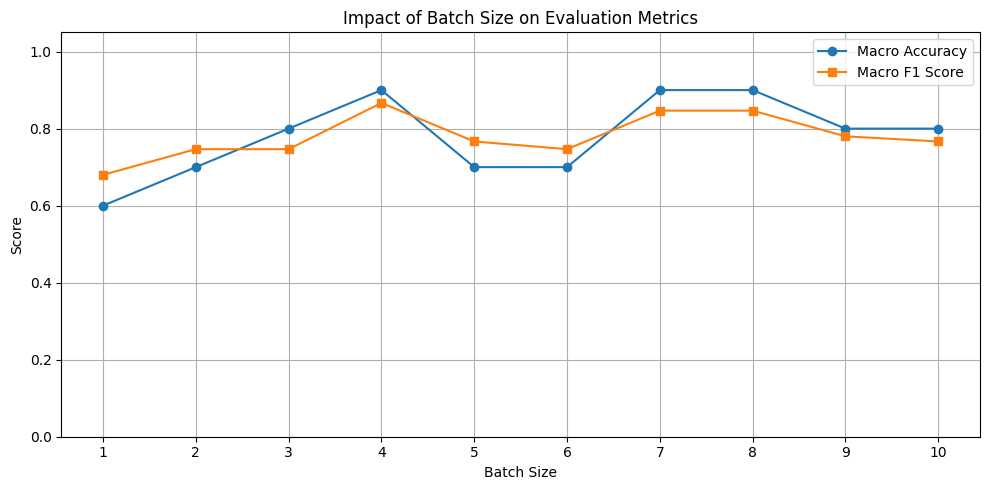

In [41]:
tuning_results = batch_size_tuning(fig_df, max_batch_size=10)


### Apply Figure of Speech tagging to the text corpus

In [42]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hadrienstrichard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
def detect_figures_in_text_batched(text: str, batch_size: int = 10) -> dict:
    """
    Tokenizes text into sentences, processes them in batches, and returns figure counts.
    """
    sentences = sent_tokenize(text, language='french')
    counts = {f"fig_{fig}": 0 for fig in FIGURES}

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        try:
            results = detect_figures_batch(batch)
        except Exception as e:
            print(f"❌ Erreur API sur le batch {i}-{i + batch_size}: {e}")
            continue

        for result in results:
            if isinstance(result, dict):
                for fig in FIGURES:
                    try:
                        if result.get(fig, False):
                            counts[f"fig_{fig}"] += 1
                    except Exception as e:
                        print(f"⚠️ Erreur lors du comptage sur '{fig}': {e}")
            else:
                print(f"⚠️ Résultat inattendu ignoré (non-dict): {result}")

    return counts


def add_figure_counts_to_df_batched(df, text_column="Cleaned_Text", batch_size=10, output_path="figures_results.csv"):
    """
    Applies batched figure detection to each row of the DataFrame.
    Returns full DataFrame with detection columns.
    Uses output_path to save partial progress and support resume.
    """
    tqdm.pandas()

    # Charger les données déjà traitées si elles existent
    if os.path.exists(output_path):
        processed_df = pd.read_csv(output_path)
                # ✅ Identifier les colonnes de figures
        fig_cols = [col for col in processed_df.columns if col.startswith("fig_")]
        # ✅ Supprimer les dernières lignes vides (somme des fig = 0 ou NaN)
        while len(processed_df) > 0 and (
            processed_df[fig_cols].iloc[-1].fillna(0).sum() == 0
        ):
            processed_df = processed_df.iloc[:-1]
        already_processed_ids = set(processed_df.index)
        print(f"✅ Reprise : {len(already_processed_ids)} lignes déjà traitées.")
    else:
        processed_df = pd.DataFrame()
        already_processed_ids = set()

    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="🔍 Détection figures"):
        if idx in already_processed_ids:
            continue

        try:
            result = detect_figures_in_text_batched(row[text_column], batch_size=batch_size)
        except Exception as e:
            print(f"❌ Erreur sur index {idx}: {e}")
            result = {f"fig_{fig}": None for fig in FIGURES}  # ou 0 si tu préfères

        result["index"] = idx
        results.append(result)

        # Sauvegarder en temps réel
        if len(results) >= 1:
            partial_df = pd.DataFrame(results).set_index("index")
            processed_df = pd.concat([processed_df, partial_df])
            processed_df.to_csv(output_path)
            results = []  # vider pour ne pas re-sauvegarder

    # Fusion finale
    full_df = df.copy()
    processed_df = processed_df.sort_index()
    for col in processed_df.columns:
        full_df[col] = processed_df[col]

    return full_df


In [47]:
fos_df = add_figure_counts_to_df_batched(texts, text_column="Cleaned_Text", batch_size=10)

✅ Reprise : 3237 lignes déjà traitées.


🔍 Détection figures:  84%|████████▍ | 3245/3858 [05:23<04:38,  2.20it/s]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 8 column 459 (char 2044)


🔍 Détection figures:  85%|████████▍ | 3264/3858 [17:50<6:17:51, 38.17s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 4 column 20 (char 605)


🔍 Détection figures:  85%|████████▍ | 3273/3858 [24:17<6:37:00, 40.72s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting property name enclosed in double quotes: line 127 column 1 (char 7122)
⚠️ Tentative 2 — erreur de parsing : Expecting property name enclosed in double quotes: line 127 column 1 (char 7122)
⚠️ Tentative 3 — erreur de parsing : Expecting property name enclosed in double quotes: line 127 column 1 (char 7122)
❌ Parsing échoué après 3 tentatives. Contenu mis de côté pour inspection.


🔍 Détection figures:  85%|████████▍ | 3275/3858 [25:54<7:06:25, 43.89s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 121 column 5 (char 4752)
⚠️ Tentative 2 — erreur de parsing : Expecting ',' delimiter: line 121 column 5 (char 4752)
⚠️ Tentative 3 — erreur de parsing : Expecting ',' delimiter: line 121 column 5 (char 4752)
❌ Parsing échoué après 3 tentatives. Contenu mis de côté pour inspection.


🔍 Détection figures:  85%|████████▌ | 3286/3858 [32:51<4:59:22, 31.40s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 121 column 5 (char 5094)


🔍 Détection figures:  86%|████████▌ | 3325/3858 [1:02:34<7:26:35, 50.27s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 120 column 483 (char 4330)


🔍 Détection figures:  86%|████████▋ | 3329/3858 [1:05:27<6:19:12, 43.01s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 15 column 3 (char 818)


🔍 Détection figures:  87%|████████▋ | 3343/3858 [1:17:40<7:41:23, 53.75s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting property name enclosed in double quotes: line 55 column 46 (char 1544)
⚠️ Tentative 2 — erreur de parsing : Expecting property name enclosed in double quotes: line 55 column 46 (char 1544)


🔍 Détection figures:  87%|████████▋ | 3368/3858 [1:37:52<6:44:57, 49.59s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 10 column 46 (char 2453)


🔍 Détection figures:  89%|████████▉ | 3434/3858 [2:29:41<5:00:24, 42.51s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 6 column 427 (char 1528)


🔍 Détection figures:  90%|█████████ | 3485/3858 [3:14:28<6:21:02, 61.29s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 7 column 195 (char 1539)
⚠️ Tentative 2 — erreur de parsing : Expecting ',' delimiter: line 7 column 195 (char 1539)
⚠️ Tentative 3 — erreur de parsing : Expecting ',' delimiter: line 7 column 195 (char 1539)
❌ Parsing échoué après 3 tentatives. Contenu mis de côté pour inspection.


🔍 Détection figures:  91%|█████████ | 3511/3858 [3:40:31<4:13:40, 43.86s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 8 column 586 (char 2275)
⚠️ Tentative 2 — erreur de parsing : Expecting ',' delimiter: line 8 column 586 (char 2275)


🔍 Détection figures:  92%|█████████▏| 3547/3858 [4:09:59<4:37:48, 53.60s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 55 column 18 (char 1432)


🔍 Détection figures:  93%|█████████▎| 3592/3858 [4:46:21<3:51:27, 52.21s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 4 column 57 (char 655)


🔍 Détection figures:  94%|█████████▍| 3644/3858 [5:32:37<3:11:55, 53.81s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 9 column 6 (char 2247)


🔍 Détection figures:  95%|█████████▍| 3647/3858 [5:35:38<3:26:06, 58.61s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 6 column 105 (char 1601)


🔍 Détection figures:  95%|█████████▍| 3658/3858 [5:45:42<3:06:02, 55.81s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 120 column 18 (char 3919)


🔍 Détection figures:  95%|█████████▍| 3662/3858 [5:49:48<3:15:57, 59.99s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 55 column 18 (char 2122)


🔍 Détection figures:  95%|█████████▌| 3681/3858 [6:08:00<2:51:42, 58.21s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 121 column 5 (char 5187)


🔍 Détection figures:  95%|█████████▌| 3683/3858 [6:09:34<2:33:09, 52.51s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 11 column 811 (char 4120)


🔍 Détection figures:  96%|█████████▌| 3691/3858 [6:16:50<2:45:03, 59.30s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 10 column 302 (char 2490)


🔍 Détection figures:  96%|█████████▌| 3700/3858 [6:26:02<2:54:06, 66.11s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 4 column 118 (char 780)


🔍 Détection figures:  96%|█████████▌| 3710/3858 [6:34:58<2:00:47, 48.97s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 4 column 102 (char 670)


🔍 Détection figures:  97%|█████████▋| 3731/3858 [6:52:34<1:59:23, 56.40s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 15 column 3 (char 878)


🔍 Détection figures:  98%|█████████▊| 3782/3858 [7:33:29<1:17:37, 61.29s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 3 column 715 (char 720)


🔍 Détection figures:  99%|█████████▊| 3804/3858 [7:53:17<54:53, 61.00s/it]  

⚠️ Tentative 1 — erreur de parsing : Certains éléments ne sont pas des dictionnaires: line 1 column 1 (char 0)


🔍 Détection figures:  99%|█████████▊| 3808/3858 [7:58:19<1:00:29, 72.58s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 8 column 335 (char 1773)


🔍 Détection figures:  99%|█████████▉| 3824/3858 [8:14:37<41:50, 73.83s/it]  

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 7 column 60 (char 1688)


🔍 Détection figures: 100%|█████████▉| 3845/3858 [8:36:45<12:24, 57.29s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting value: line 3 column 15 (char 20)


🔍 Détection figures: 100%|█████████▉| 3846/3858 [8:37:30<10:43, 53.62s/it]

⚠️ Tentative 1 — erreur de parsing : Expecting ',' delimiter: line 121 column 5 (char 3743)


🔍 Détection figures: 100%|██████████| 3858/3858 [8:49:41<00:00,  8.24s/it]


In [48]:
# Check the number of failed sentences

failure_marker = "--- Échec sur batch ---"
count = 0

with open("parsing_failures.log", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip() == failure_marker:
            count += 1

print(f"Nombre de failures détectés : {count}")

Nombre de failures détectés : 26


In [49]:
fos_df.head()

,Author,Title,URL,Excerpt_ID,Excerpt_Text,Cleaned_Text,Tokens,lex_WordCount,fw_étés,fw_moi,...,fig_Comparaison,fig_Métaphore,fig_Personnification,fig_Hyperbole,fig_Litote,fig_Antithèse,fig_Oxymore,fig_Répétition,fig_Énumération,fig_Euphémisme
0,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_21,«--Hé! hé! monsieur Antoine; voulez-vous venir...,"""--hé! hé! monsieur antoine; voulez-vous venir...","[``, --, hé, !, hé, !, monsieur, antoine, ;, v...",1622,0.0,0.001850,...,4,2,0,1,3,0,0,2,14,0
1,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_51,"«Cette demoiselle est fort taquine, pensa-t-il...","""cette demoiselle est fort taquine, pensa-t-il...","[``, cette, demoiselle, est, fort, taquine, ,,...",1644,0.0,0.001217,...,10,1,1,1,1,1,0,1,9,0
2,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_50,"Mais l'accent, mais le regard, trouvent dans l...","mais l'accent, mais le regard, trouvent dans l...","[mais, l'accent, ,, mais, le, regard, ,, trouv...",1660,0.0,0.001205,...,8,1,1,0,3,1,0,2,7,1
3,George Sand,"Le péché de Monsieur Antoine, Tome 1",https://www.gutenberg.org/ebooks/12367,12367_14,"--Qu'il s'en aille! et toi ... garde ta place,...","--qu'il s'en aille! et toi ... garde ta place,...","[--, qu'il, s'en, aille, !, et, toi, ..., gard...",1510,0.0,0.001987,...,7,2,0,3,0,0,0,0,4,1
4,George Sand,Pauline,https://www.gutenberg.org/ebooks/12447,12447_11,"Mais, quoiqu'elle y mît de l'affection et de l...","mais, quoiqu'elle y mît de l'affection et de l...","[mais, ,, quoiqu'elle, y, mît, de, l'affection...",1639,0.0,0.002441,...,6,1,2,1,3,2,0,0,2,1


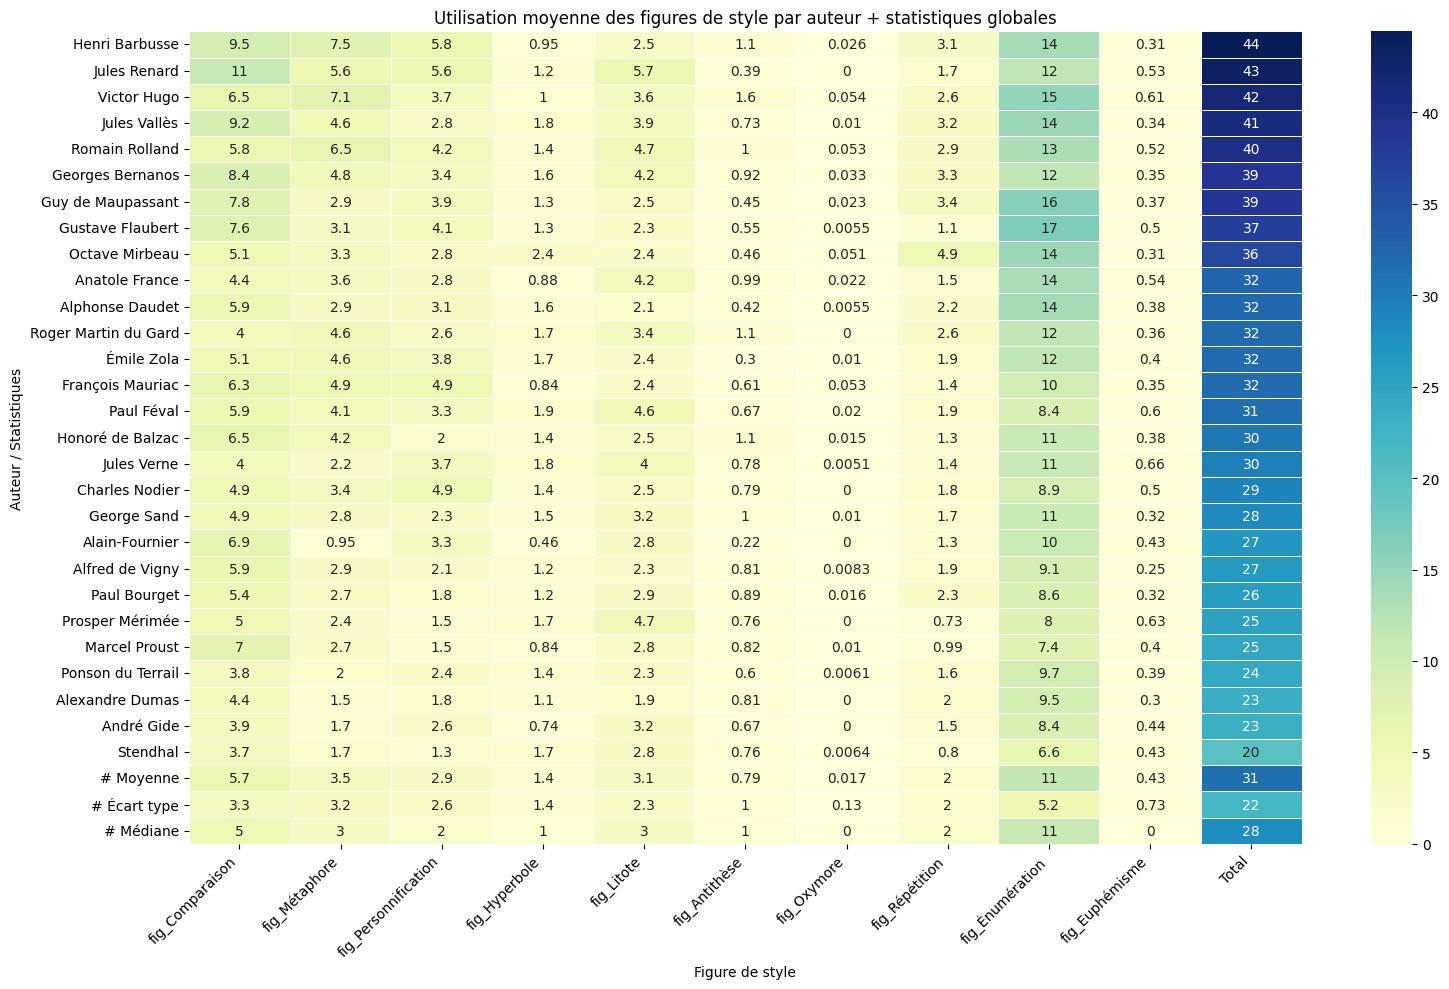

In [61]:
# 1. Colonnes de figures de style
fig_cols = [col for col in fos_df.columns if col.startswith('fig_')]

# 2. Moyennes par auteur
heatmap_data = fos_df.groupby('Author')[fig_cols].mean()

# 3. Ajout de la colonne Total
heatmap_data['Total'] = heatmap_data.sum(axis=1)

# 4. Tri des auteurs par Total décroissant
heatmap_data = heatmap_data.sort_values(by='Total', ascending=False)

# 5. Statistiques globales (moyenne, écart type, médiane) pour chaque figure
stats = fos_df[fig_cols].agg(['mean', 'std', 'median'])

# 6. Ajout d'une colonne "Total" pour les stats
stats['Total'] = stats.sum(axis=1)

# 7. Réindexer pour être compatible avec la heatmap (même ordre de colonnes)
stats = stats[heatmap_data.columns]

# 8. Fusion des deux : auteurs + stats comme lignes
combined = pd.concat([heatmap_data, stats.rename(index={
    'mean': '# Moyenne',
    'std': '# Écart type',
    'median': '# Médiane'
})])

# 9. Affichage de la heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(combined, annot=True, cmap='YlGnBu', linewidths=0.5)

plt.title("Utilisation moyenne des figures de style par auteur + statistiques globales")
plt.xlabel("Figure de style")
plt.ylabel("Auteur / Statistiques")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [56]:
fos_df.filter(like="fig_").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   fig_Comparaison       3858 non-null   int64
 1   fig_Métaphore         3858 non-null   int64
 2   fig_Personnification  3858 non-null   int64
 3   fig_Hyperbole         3858 non-null   int64
 4   fig_Litote            3858 non-null   int64
 5   fig_Antithèse         3858 non-null   int64
 6   fig_Oxymore           3858 non-null   int64
 7   fig_Répétition        3858 non-null   int64
 8   fig_Énumération       3858 non-null   int64
 9   fig_Euphémisme        3858 non-null   int64
dtypes: int64(10)
memory usage: 301.5 KB


In [51]:
fos_df.filter(like="fig_").describe()

,fig_Comparaison,fig_Métaphore,fig_Personnification,fig_Hyperbole,fig_Litote,fig_Antithèse,fig_Oxymore,fig_Répétition,fig_Énumération,fig_Euphémisme
count,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000
mean,5.749611,3.522291,2.923017,1.406169,3.114567,0.791602,0.016589,1.984448,11.306636,0.432867
std,3.301312,3.234207,2.646885,1.384058,2.327890,1.040339,0.131738,2.021345,5.221916,0.731015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,7.000000,0.000000
50%,5.000000,3.000000,2.000000,1.000000,3.000000,1.000000,0.000000,2.000000,11.000000,0.000000
75%,8.000000,5.000000,4.000000,2.000000,4.000000,1.000000,0.000000,3.000000,15.000000,1.000000
max,23.000000,33.000000,21.000000,13.000000,14.000000,8.000000,2.000000,31.000000,37.000000,7.000000


## Final DF

In [ ]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 223 entries, Author to lex_MarkerCount
dtypes: float64(203), int64(13), object(7)
memory usage: 6.6+ MB


In [ ]:
# Taille du dataset
print("Shape:", texts.shape)

# Types de données
print(texts.dtypes.value_counts())

# Nombre total de valeurs manquantes
print("Missing values total:", texts.isna().sum().sum())

print(texts.isna().sum().sum() / (texts.shape[0] * texts.shape[1]) * 100, "% of total values are missing")


Shape: (3858, 223)
float64    203
int64       13
object       7
Name: count, dtype: int64
Missing values total: 0
0.0 % of total values are missing


In [ ]:
# Étape 1 : Ne garder que les features + la colonne "Author"
# On supprime tout sauf "Author" et les colonnes de type numérique (features)
cols_to_keep = ['Author'] + [col for col in texts.columns if col not in ['Title', 'URL', 'Excerpt_ID', 'Excerpt_Text', 'Cleaned_Text', 'Tokens'] and col != 'Author']
texts = texts[cols_to_keep]

# Vérification
print("New shape after column filtering:", texts.shape)

# Étape 2 : Remplir les NaN par la moyenne PAR CLASSE (par 'Author')
# Cela suppose que toutes les colonnes sauf 'Author' sont numériques
feature_cols = [col for col in texts.columns if col != 'Author']

# On remplit les NaN par la moyenne des valeurs pour chaque auteur
texts[feature_cols] = texts.groupby('Author')[feature_cols].transform(lambda x: x.fillna(x.mean()))

# Vérification post-traitement
print("Total remaining NaNs:", texts.isna().sum().sum())


New shape after column filtering: (3858, 217)
Total remaining NaNs: 0


In [ ]:
# Étape 1 : supprimer les colonnes avec uniquement des NaN
nan_cols = texts.columns[texts.isna().all()].tolist()
print("Colonnes supprimées car entièrement nulles (NaN) :")
print(nan_cols)
texts = texts.dropna(axis=1, how='all')

# Étape 2 : supprimer les colonnes avec uniquement des zéros (sauf colonne 'Author')
feature_cols = [col for col in texts.columns if col != 'Author']
zero_cols = [col for col in feature_cols if (texts[col] == 0).all()]

print(f"Nombre de colonnes entièrement nulles ou égales à zéro : {len(zero_cols)}")
print("Colonnes supprimées car uniquement constituées de zéros :")
print(zero_cols)

# Drop them
texts.drop(columns=zero_cols, inplace=True)

# Vérification
print("Shape finale du dataset :", texts.shape)


Nombre de colonnes entièrement nulles ou égales à zéro : 9
Shape finale du dataset : (3858, 208)


In [ ]:
texts.to_parquet("../Data/stylo_embedds.parquet", index=False)

In [ ]:
# Extraire les préfixes avant le premier underscore
prefixes = texts.columns.str.extract(r'^([^_]+)_')[0]

# Remplacer les NaN (pas de préfixe) par "autre"
prefixes = prefixes.fillna("autre")

# Compter les occurrences de chaque préfixe (ou "autre")
prefix_counts = prefixes.value_counts()

print(prefix_counts)

# Filtrer les colonnes qui ne commencent PAS par "fw_"
non_fw_columns = [col for col in texts.columns if not col.startswith('fw_')]

# Afficher la liste
print(non_fw_columns)

0
fw       149
POS       11
sent       9
lex        8
syn        8
pun        6
tense      6
gfw        5
dep        5
autre      1
Name: count, dtype: int64
['Author', 'lex_WordCount', 'gfw_article', 'gfw_preposition', 'gfw_pronoun', 'gfw_conjunction', 'gfw_auxiliary', 'POS_NOUN', 'POS_VERB', 'POS_AUX', 'POS_ADJ', 'POS_ADV', 'POS_PRON', 'POS_DET', 'POS_ADP', 'POS_CCONJ', 'POS_SCONJ', 'POS_INTJ', 'lex_TTR', 'lex_Hapax_Ratio', 'lex_AvgWordLen', 'lex_YuleK', 'lex_SimpsonD', 'lex_Entropy', 'syn_Complexity', 'syn_NomVerbRatio', 'syn_AdjNounRatio', 'syn_AdvVerbRatio', 'syn_AlternanceRate', 'pun_Period_Count', 'pun_Comma_Count', 'pun_Semicolon_Count', 'pun_QuestionMark_Count', 'pun_ExclamationMark_Count', 'pun_Colon_Count', 'dep_advcl', 'dep_acl', 'dep_ccomp', 'dep_xcomp', 'dep_mark', 'sent_Count', 'sent_AvgLength', 'sent_MinLength', 'sent_MaxLength', 'sent_StdLength', 'sent_PassiveRatio', 'sent_Interrogative', 'sent_Exclamative', 'sent_Exclamative_INTJ', 'tense_pres_ind', 'tense_past_ind', 

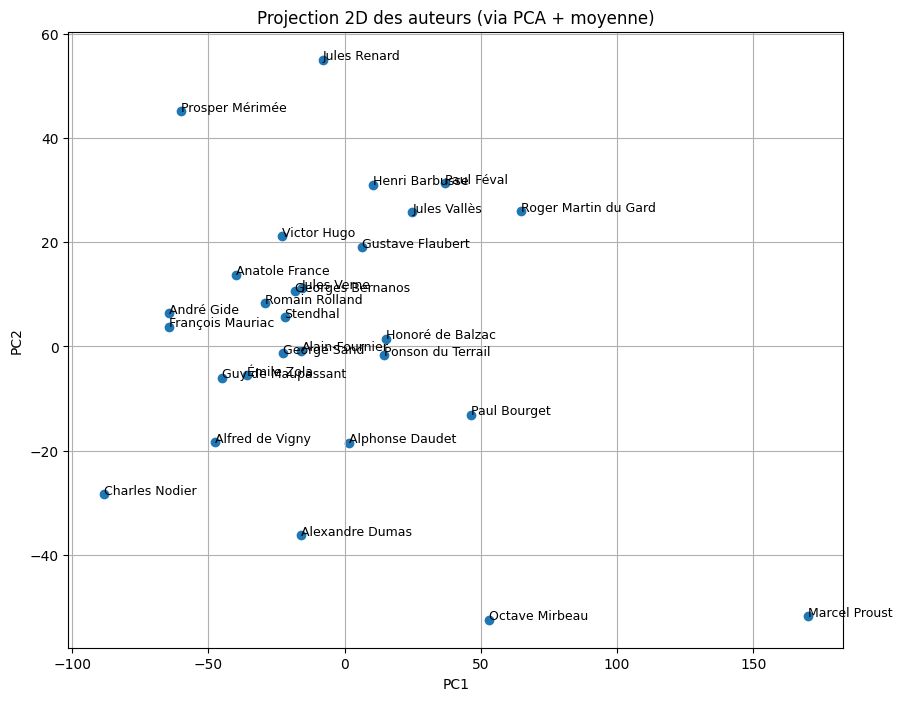

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = texts.copy()

# Supposons df est ton DataFrame
X = df.drop(columns=["Author"])
y = df["Author"]

# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Créer un DataFrame avec les coordonnées PCA et l'auteur
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Author"] = y

# Moyenne des livres par auteur
author_centroids = df_pca.groupby("Author")[["PC1", "PC2"]].mean().reset_index()

# Affichage
plt.figure(figsize=(10, 8))
plt.scatter(author_centroids["PC1"], author_centroids["PC2"])

for _, row in author_centroids.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Author"], fontsize=9)

plt.title("Projection 2D des auteurs (via PCA + moyenne)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## Final DF with Figure of Speech tagging

In [69]:
fos_df.head()

,Author,lex_WordCount,fw_étés,fw_moi,fw_étions,fw_ont,fw_auront,fw_en,fw_eusse,fw_nous,...,fig_Comparaison,fig_Métaphore,fig_Personnification,fig_Hyperbole,fig_Litote,fig_Antithèse,fig_Oxymore,fig_Répétition,fig_Énumération,fig_Euphémisme
0,George Sand,1622,0.0,0.001850,0.0,0.000000,0.0,0.011097,0.0,0.005549,...,4,2,0,1,3,0,0,2,14,0
1,George Sand,1644,0.0,0.001217,0.0,0.000000,0.0,0.012774,0.0,0.000000,...,10,1,1,1,1,1,0,1,9,0
2,George Sand,1660,0.0,0.001205,0.0,0.000602,0.0,0.007831,0.0,0.011446,...,8,1,1,0,3,1,0,2,7,1
3,George Sand,1510,0.0,0.001987,0.0,0.000662,0.0,0.015232,0.0,0.001987,...,7,2,0,3,0,0,0,0,4,1
4,George Sand,1639,0.0,0.002441,0.0,0.000000,0.0,0.010372,0.0,0.001220,...,6,1,2,1,3,2,0,0,2,1


In [84]:
# Taille du dataset
print("Shape:", fos_df.shape)

# Types de données
print(fos_df.dtypes.value_counts())

# Nombre total de valeurs manquantes
print("Missing values total:", fos_df.isna().sum().sum())

print(fos_df.isna().sum().sum() / (fos_df.shape[0] * fos_df.shape[1]) * 100, "% of total values are missing")


Shape: (3858, 227)
float64    203
int64       23
object       1
Name: count, dtype: int64
Missing values total: 0
0.0 % of total values are missing


In [87]:
# Étape 1 : Ne garder que les features + la colonne "Author"
# On supprime tout sauf "Author" et les colonnes de type numérique (features)
cols_to_keep = ['Author'] + [col for col in fos_df.columns if col not in ['Title', 'URL', 'Excerpt_ID', 'Excerpt_Text', 'Cleaned_Text', 'Tokens'] and col != 'Author']
fos_df = fos_df[cols_to_keep]

# Vérification
print("New shape after column filtering:", fos_df.shape)

# Étape 2 : Remplir les NaN par la moyenne PAR CLASSE (par 'Author')
# Cela suppose que toutes les colonnes sauf 'Author' sont numériques
feature_cols = [col for col in fos_df.columns if col != 'Author']

# On remplit les NaN par la moyenne des valeurs pour chaque auteur
fos_df[feature_cols] = fos_df.groupby('Author')[feature_cols].transform(lambda x: x.fillna(x.mean()))

# Vérification post-traitement
print("Total remaining NaNs:", fos_df.isna().sum().sum())


New shape after column filtering: (3858, 227)
Total remaining NaNs: 0


In [88]:
# Étape 1 : supprimer les colonnes avec uniquement des NaN
nan_cols = fos_df.columns[fos_df.isna().all()].tolist()
print("Colonnes supprimées car entièrement nulles (NaN) :")
print(nan_cols)
fos_df = fos_df.dropna(axis=1, how='all')

# Étape 2 : supprimer les colonnes avec uniquement des zéros (sauf colonne 'Author')
feature_cols = [col for col in fos_df.columns if col != 'Author']
zero_cols = [col for col in feature_cols if (fos_df[col] == 0).all()]

print(f"Nombre de colonnes entièrement nulles ou égales à zéro : {len(zero_cols)}")
print("Colonnes supprimées car uniquement constituées de zéros :")
print(zero_cols)

# Drop them
fos_df.drop(columns=zero_cols, inplace=True)

# Vérification
print("Shape finale du dataset :", fos_df.shape)


Colonnes supprimées car entièrement nulles (NaN) :
[]
Nombre de colonnes entièrement nulles ou égales à zéro : 9
Colonnes supprimées car uniquement constituées de zéros :
['fw_ayants', 'fw_étantes', 'fw_ayantes', 'fw_étée', 'fw_étants', 'fw_ayante', 'fw_étante', 'fw_étées', 'dep_relcl']
Shape finale du dataset : (3858, 218)


In [89]:
fos_df.to_parquet("../Data/stylo_embedds_with_fos.parquet", index=False)

In [90]:
# Extraire les préfixes avant le premier underscore
prefixes = fos_df.columns.str.extract(r'^([^_]+)_')[0]

# Remplacer les NaN (pas de préfixe) par "autre"
prefixes = prefixes.fillna("autre")

# Compter les occurrences de chaque préfixe (ou "autre")
prefix_counts = prefixes.value_counts()

print(prefix_counts)

# Filtrer les colonnes qui ne commencent PAS par "fw_"
non_fw_columns = [col for col in fos_df.columns if not col.startswith('fw_')]

# Afficher la liste
print(non_fw_columns)

0
fw       149
POS       11
fig       10
sent       9
lex        8
syn        8
pun        6
tense      6
gfw        5
dep        5
autre      1
Name: count, dtype: int64
['Author', 'lex_WordCount', 'gfw_article', 'gfw_preposition', 'gfw_pronoun', 'gfw_conjunction', 'gfw_auxiliary', 'POS_NOUN', 'POS_VERB', 'POS_AUX', 'POS_ADJ', 'POS_ADV', 'POS_PRON', 'POS_DET', 'POS_ADP', 'POS_CCONJ', 'POS_SCONJ', 'POS_INTJ', 'lex_TTR', 'lex_Hapax_Ratio', 'lex_AvgWordLen', 'lex_YuleK', 'lex_SimpsonD', 'lex_Entropy', 'syn_Complexity', 'syn_NomVerbRatio', 'syn_AdjNounRatio', 'syn_AdvVerbRatio', 'syn_AlternanceRate', 'pun_Period_Count', 'pun_Comma_Count', 'pun_Semicolon_Count', 'pun_QuestionMark_Count', 'pun_ExclamationMark_Count', 'pun_Colon_Count', 'dep_advcl', 'dep_acl', 'dep_mark', 'dep_ccomp', 'dep_xcomp', 'sent_Count', 'sent_AvgLength', 'sent_MinLength', 'sent_MaxLength', 'sent_StdLength', 'sent_PassiveRatio', 'sent_Interrogative', 'sent_Exclamative', 'sent_Exclamative_INTJ', 'tense_pres_ind', 'tens

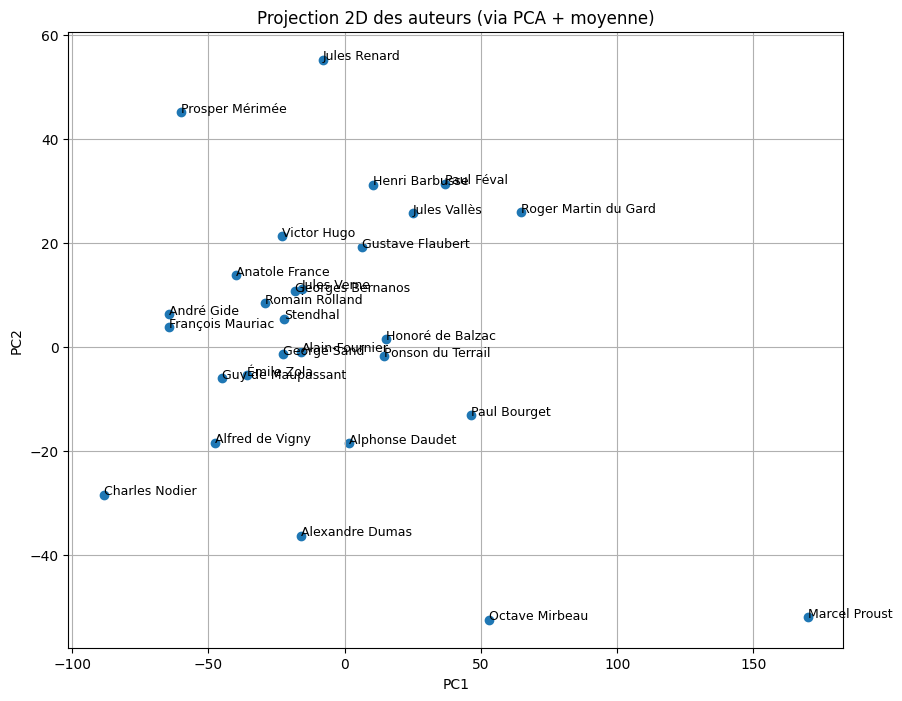

In [92]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = fos_df.copy()

# Supposons df est ton DataFrame
X = df.drop(columns=["Author"])
y = df["Author"]

# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Créer un DataFrame avec les coordonnées PCA et l'auteur
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Author"] = y

# Moyenne des livres par auteur
author_centroids = df_pca.groupby("Author")[["PC1", "PC2"]].mean().reset_index()

# Affichage
plt.figure(figsize=(10, 8))
plt.scatter(author_centroids["PC1"], author_centroids["PC2"])

for _, row in author_centroids.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Author"], fontsize=9)

plt.title("Projection 2D des auteurs (via PCA + moyenne)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()